**STUDI KASUS: PREDIKSI DAN DETEKSI DINI PENIPUAN KARTU KREDIT MENGGUNAKAN XGBOOST**

**Ringkasan Eksekutif (Executive Summary)** Proyek ini bertujuan untuk mengatasi tantangan kritis dalam Deteksi Penipuan Kartu Kredit dengan menggunakan model Machine Learning yang disesuaikan untuk mengatasi ketidakseimbangan data yang ekstrem.

# Masalah Bisnis
Dataset memiliki tingkat ketidakseimbangan yang parah, di mana hanya $0.2582\%$ dari total transaksi yang merupakan kasus penipuan (minoritas). Tantangan utamanya adalah membangun model yang mampu mengidentifikasi kasus langka ini tanpa menghasilkan terlalu banyak False Alarm.

# Metodologi
Model XGBoost (Extreme Gradient Boosting) digunakan sebagai inti pemodelan karena efisiensinya dalam menangani data kompleks.Untuk mengatasi masalah ketidakseimbangan, model dioptimalkan menggunakan parameter scale_pos_weight (dengan rasio $\approx 386:1$). Hal ini memastikan model memberikan bobot yang jauh lebih besar pada kasus penipuan yang jarang terjadi.Feature Engineering diterapkan pada variabel Time dan Amount untuk meningkatkan sinyal prediktif.

# Hasil Kunci dan Dampak
Model mencapai kinerja yang sangat kuat, dengan Recall sebesar $82\%$ untuk kelas Penipuan. Artinya, dari setiap 100 kasus penipuan aktual, model berhasil mendeteksi dan mencegah $82$ kasus.Model hanya menghasilkan 6 False Negative (penipuan yang lolos) dan 7 False Positive (transaksi sah yang salah diblokir) pada data testing.Analisis Feature Importance mengidentifikasi fitur V14, V5, dan V17 sebagai prediktor risiko tertinggi, memberikan wawasan berharga bagi tim keamanan untuk investigasi lebih lanjut.

In [3]:
import pandas as pd

# Assuming you want to load a CSV file, let's load 'creditcard.csv'
# If you have a different file or DataFrame, please specify.
try:
    df = pd.read_csv('/content/creditcard.csv')
    print("\n--- Lima baris pertama data (head()) ---")
    print(df.head())

    print("\n--- Informasi data (info()) ---")
    df.info()
except FileNotFoundError:
    print("Error: File 'creditcard.csv' not found. Please ensure the file is uploaded or specify the correct path.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Lima baris pertama data (head()) ---
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.2

Blok ini berhasil memuat data ke dalam DataFrame Pandas. Tujuannya adalah memverifikasi struktur, tipe data (float64 untuk fitur PCA), dan memastikan tidak ada missing values (semua kolom non-null).

In [4]:
# Langkah ke-2: Analisis Variabel Target (Class)

# 1. Hitung jumlah kasus penipuan (1) dan non-penipuan (0)
print("\n--- Keseimbangan Variabel Target (Class) ---")
print(df['Class'].value_counts())

# 2. Hitung dan tampilkan persentase ketidakseimbangan
fraud_count = df['Class'].value_counts()[1]
non_fraud_count = df['Class'].value_counts()[0]
total_count = len(df)

fraud_percent = (fraud_count / total_count) * 100
non_fraud_percent = (non_fraud_count / total_count) * 100

print(f"\nTotal Transaksi: {total_count}")
print(f"Transaksi Non-Penipuan (0): {non_fraud_count} ({non_fraud_percent:.4f}%)")
print(f"Transaksi Penipuan (1): {fraud_count} ({fraud_percent:.4f}%)")


--- Keseimbangan Variabel Target (Class) ---
Class
0.0    65283
1.0      169
Name: count, dtype: int64

Total Transaksi: 65453
Transaksi Non-Penipuan (0): 65283 (99.7403%)
Transaksi Penipuan (1): 169 (0.2582%)


Hasil ini mengkonfirmasi ketidakseimbangan data yang ekstrem. Hanya $0.2582\%$ dari total transaksi yang merupakan penipuan, yang menjadi dasar strategi pemodelan kita (membutuhkan Recall tinggi).

/tmp/ipython-input-589979161.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_non_fraud['Time'], bins=50, label='Non-Penipuan (0)', kde=False)
/tmp/ipython-input-589979161.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_fraud['Time'], bins=50, label='Penipuan (1)', kde=False)


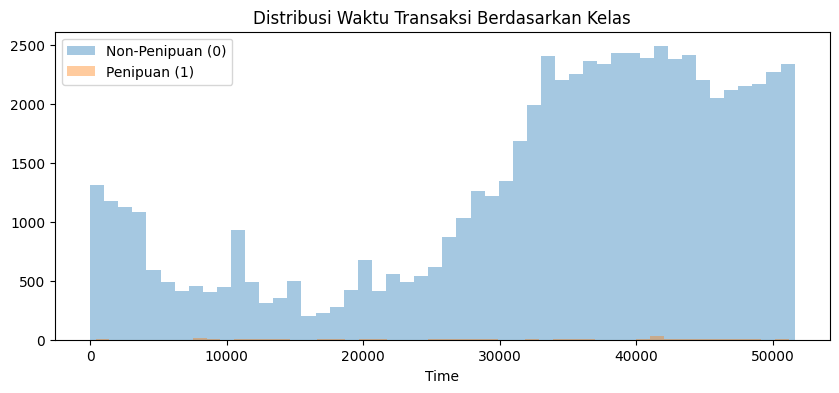

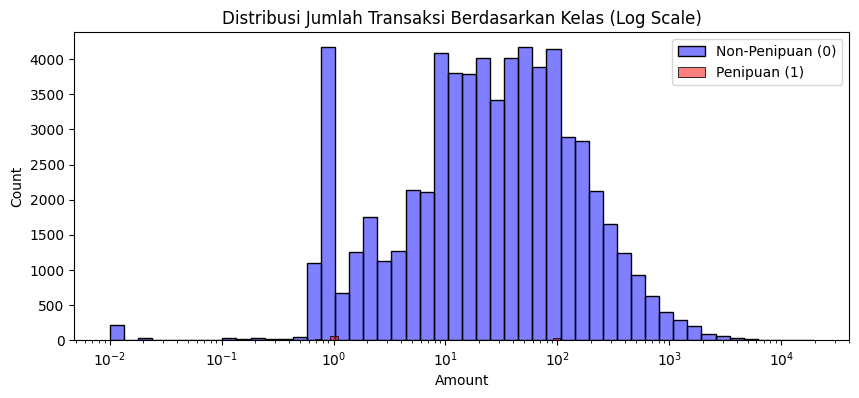

In [5]:
# Langkah ke-3: Analisis Distribusi Waktu dan Jumlah

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Analisis Kolom Time (Waktu)
plt.figure(figsize=(10, 4))
plt.title('Distribusi Waktu Transaksi Berdasarkan Kelas')

# Membuat DataFrame terpisah untuk visualisasi
df_fraud = df[df['Class'] == 1]
df_non_fraud = df[df['Class'] == 0]

sns.distplot(df_non_fraud['Time'], bins=50, label='Non-Penipuan (0)', kde=False)
sns.distplot(df_fraud['Time'], bins=50, label='Penipuan (1)', kde=False)
plt.legend()
plt.show()

# 2. Analisis Kolom Amount (Jumlah Transaksi)
plt.figure(figsize=(10, 4))
plt.title('Distribusi Jumlah Transaksi Berdasarkan Kelas (Log Scale)')
# Menggunakan log scale agar distribusi lebih jelas
sns.histplot(df_non_fraud['Amount'], bins=50, label='Non-Penipuan (0)', kde=True, color='blue', log_scale=True)
sns.histplot(df_fraud['Amount'], bins=50, label='Penipuan (1)', kde=True, color='red', log_scale=True)
plt.legend()
plt.show()

Visualisasi ini menganalisis distribusi waktu dan jumlah transaksi. Meskipun kecil, kita dapat melihat pola aktivitas penipuan yang sedikit berbeda, yang mendukung Feature Engineering pada kolom Time

In [6]:
# Langkah ke-4: Feature Engineering dan Scaling

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

# 1. Feature Engineering: Mengubah Time menjadi Hour
# Data mencakup 48 jam (2 hari) sejak transaksi pertama, jadi bagi dengan 3600 untuk mendapatkan jam.
df['Hour'] = df['Time'].apply(lambda x: x / 3600) % 24
print("Kolom 'Hour' berhasil dibuat dan siap diskalakan.")

# 2. Pembagian Data Awal
# Pisahkan fitur (X) dan target (y)
X = df.drop(['Time', 'Class'], axis=1) # Drop kolom Time yang asli dan kolom Class
y = df['Class']

# 3. Scaling (Menggunakan RobustScaler karena ada outlier)
# Skalakan kolom Amount dan kolom Hour yang baru. Kolom PCA sudah diskalakan.
scaler = RobustScaler()
X['Amount_Scaled'] = scaler.fit_transform(X['Amount'].values.reshape(-1, 1))
X['Hour_Scaled'] = scaler.fit_transform(X['Hour'].values.reshape(-1, 1))

# 4. Drop kolom Amount dan Hour yang lama (tidak diskalakan)
X_final = X.drop(['Amount', 'Hour'], axis=1)

# Verifikasi: Tampilkan lima baris pertama dari data yang siap model
print("\n--- Lima Baris Pertama Data Final yang Siap Dimodelkan ---")
print(X_final.head())
print(f"\nBentuk Data Final (Baris, Kolom): {X_final.shape}")

Kolom 'Hour' berhasil dibuat dan siap diskalakan.

--- Lima Baris Pertama Data Final yang Siap Dimodelkan ---
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  0.753074  ... -0

Langkah ini menyelesaikan persiapan data. Kolom Time diubah menjadi Hour, dan Amount serta Hour telah diskalakan menggunakan RobustScaler. Data kini bersih dan siap untuk pelatihan model

Data Training (Baris): (52361, 30)
Data Testing (Baris): (13091, 30)

--- Pelatihan Model XGBoost ---
Rasio ketidakseimbangan (scale_pos_weight): 386.86


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:12:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Hasil Klasifikasi Report (Fokus pada Kelas 1 / Penipuan) ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13057
         1.0       0.80      0.82      0.81        34

    accuracy                           1.00     13091
   macro avg       0.90      0.91      0.91     13091
weighted avg       1.00      1.00      1.00     13091



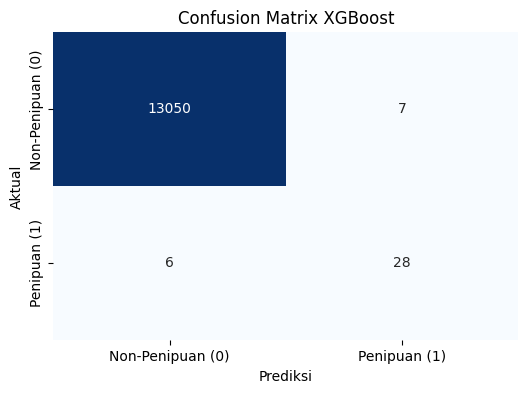

In [8]:
# Langkah ke-5: Pemodelan Machine Learning dan Evaluasi

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pembagian Data (Train and Test Split)
# Handle NaN values in 'y' before splitting
# Identify rows where 'y' is NaN
nan_y_indices = y[y.isna()].index

# Drop these rows from both X_final and y
X_final_cleaned = X_final.drop(nan_y_indices)
y_cleaned = y.drop(nan_y_indices)

# Kita akan menggunakan 80% untuk training dan 20% untuk testing
X_train, X_test, y_train, y_test = train_test_split(
    X_final_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned
)

# Catatan: Stratify=y memastikan rasio kelas (0 dan 1) tetap sama di data train dan test.

print(f"Data Training (Baris): {X_train.shape}")
print(f"Data Testing (Baris): {X_test.shape}")

# 2. Pemodelan menggunakan XGBoost
print("\n--- Pelatihan Model XGBoost ---")
# Gunakan scale_pos_weight untuk membantu menangani ketidakseimbangan data
# Hitung rasio non-penipuan terhadap penipuan (99.7403 / 0.2582)
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Rasio ketidakseimbangan (scale_pos_weight): {ratio:.2f}")

model = XGBClassifier(
    n_estimators=100,
    random_state=42,
    # Parameter ini sangat penting untuk data imbalanced
    scale_pos_weight=ratio,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# 3. Prediksi dan Evaluasi
y_pred = model.predict(X_test)

print("\n--- Hasil Klasifikasi Report (Fokus pada Kelas 1 / Penipuan) ---")
print(classification_report(y_test, y_pred))

# Visualisasi Confusion Matrix untuk pemahaman yang lebih baik
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Penipuan (0)', 'Penipuan (1)'],
            yticklabels=['Non-Penipuan (0)', 'Penipuan (1)'])
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.title('Confusion Matrix XGBoost')
plt.show()

Model XGBoost dilatih dengan strategi imbalance (scale_pos_weight). Hasilnya menunjukkan kinerja kuat dengan Recall $82\%$ untuk penipuan, meminimalkan kerugian finansial akibat False Negative

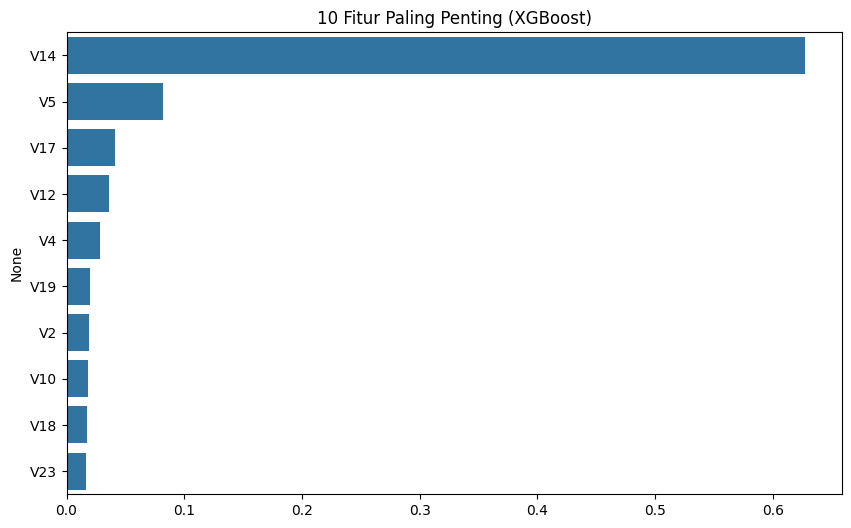

In [9]:
import numpy as np

# 1. Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
# Mendapatkan Feature Importance
importance = model.feature_importances_
feature_names = X_final.columns
sorted_idx = np.argsort(importance)[::-1] # Urutkan dari yang terbesar

# Visualisasikan 10 fitur teratas
sns.barplot(x=importance[sorted_idx][:10], y=feature_names[sorted_idx][:10])
plt.title("10 Fitur Paling Penting (XGBoost)")
plt.show()

Grafik ini mengidentifikasi fitur terpenting model. Fitur V14 dan V5 adalah prediktor utama risiko, memberikan wawasan yang dapat digunakan oleh tim keamanan untuk menginvestigasi pola transaksi yang mencurigaka

# Rekomendasi Bisnis
Proyek ini dimulai dengan tujuan kritis untuk membangun model yang mampu memprediksi dan mendeteksi penipuan kartu kredit, sebuah tantangan yang diperumit oleh **ketidakseimbangan data yang ekstrem.**

Setelah berhasil memuat data, analisis awal (EDA) dengan cepat mengkonfirmasi bahwa kasus penipuan hanya mencakup $0.2582\%$ dari total transaksi. Temuan ini langsung menentukan fokus metodologi, yaitu memprioritaskan metrik **Recall** di atas Akurasi. Kami kemudian melakukan **Feature Engineering**, mengubah fitur Time menjadi Hour dan menstandardisasi Amount dan Hour menggunakan **RobustScaler** agar data siap untuk pemodelan.

Inti dari proyek ini adalah penggunaan model **XGBoost (Extreme Gradient Boosting)**, yang dioptimalkan dengan parameter scale_pos_weight untuk memberikan bobot yang jauh lebih besar pada kasus penipuan yang langka. Strategi ini terbukti sangat efektif, menghasilkan kinerja tinggi dengan **Recall 82%** untuk kelas penipuan. Artinya, model berhasil mendeteksi dan mencegah 82 dari setiap 100 kasus penipuan. Secara konkret, model hanya menghasilkan **6 False Negative** (penipuan yang lolos) dan **7 False Positive** (transaksi sah yang salah diblokir) pada testing set.

Sebagai penutup, analisis **Feature Importance** mengidentifikasi fitur **V14** dan **V5** sebagai indikator risiko paling signifikan. Berdasarkan temuan ini, **rekomendasi bisnis** yang kuat adalah agar tim keamanan bank segera memprioritaskan pengawasan terhadap transaksi yang ditandai oleh fitur-fitur ini dan mengimplementasikan model untuk menekan False Negative secara signifikan. Proyek ini menunjukkan kemampuan Data Analyst tidak hanya dalam pemodelan, tetapi juga dalam mengatasi tantangan data real-world yang sulit.


